## Computational Astrophysics HS23

### Exercise 1

Code written by Anshak Mallik

In [2]:
#Import libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [3]:
#Function to integrate using a specific numerical method

def integrate(method, rhs, y0, T, N):
    """
    INPUT
    method: function name based on numerical method to be used [function name]
    rhs: right-hand side of equation [function of y]
    y0: intial condition [numpy array]
    T: total time [float]
    N: number of steps [int]
    
    OUTPUT
    t: timescale [numpy array]
    y: ((N+1), 4) matrix with each row being the next iteration of the result [numpy array]
    """
    
    #Initialize an empty ((N+1), 2) matrix (assuming y0 is a 2-dimensional vector)
    y = np.zeros((N+1,) + y0.shape)
    
    #Timescale
    t0 = 0.0 #beginning of timescale
    dt = T/N #timestep
    t = np.linspace(t0, T, N+1)
    
    #Initialize first row of y with initial condition
    y[0,:] = y0
    
    #Loop to update each row of y
    for i in range(0,N):
        y[i+1,:] = method(rhs, y[i,:], t0 + i*dt, dt)
    
    return t, y

### Methods

#### Explicit Euler

In [4]:
#eE step
def explicit_euler_step(rhs, y0, t0, dt):
    
    #Return step of explicit Euler
    yi = y0 + dt*rhs(t0, y0)
    return yi

In [5]:
#eE
def explicit_euler(rhs, y0, T, N):
    return integrate(explicit_euler_step, rhs, y0, T, N)

#### Runge Kutta

In [6]:
#RK step
def runge_kutta_step(B, t, y, dt):
    
    #Characteristics of Butcher table
    s = B.shape[0]-1 #shape
    c = B[:-1,0] #left column
    b = B[-1,1:] #bottom row
    A = B[:-1,1:] #remaining matrix
    
    #Check for explicitness
    isExplicit = np.allclose(np.triu(A),0)
    
    #If not explicit, need to implement implicit steps inbetween
    if isExplicit:
        k = np.zeros(np.shape(y)+(s,))
        for i in range(s):
            k[:,i] = rhs(t+c[i]*dt, y+dt*np.dot(k, A[i,:]))
    else: 
        def F(x):
            z = x.reshape((2,s))
            temp = np.zeros((2,s))
            for i in range(s):
                temp[:,i] = rhs(t+c[i]*dt, y+dt*np.dot(z, A[i,:]))
            return temp.ravel()
        k = fsolve(lambda x: x-F(x), zeros(2*s)).reshape((2,s))
        
    tnew = t+dt
    ynew = y + dt*np.squeeze(np.dot(k,b))
    
    return tnew, ynew

In [7]:
#RK
def runge_kutta(B, tstart, tend, y0, N):
    y = np.zeros((4, N+1))
    t = np.zeros((N+1,))
    
    y[:,0] = y0
    t[0] = tstart
    dt = (tend-tstart)/float(N)
    
    for i in range(N):
        t[i+1], y[:,i+1] = runge_kutta_step(B, t[i], y[:,i], dt)
        
    return t, y

##### Butcher Tableaus

In [8]:
#RK-2 (Heun's method) 
B_RK2 = np.array([[0, 0, 0], 
                 [1, 1, 0], 
                 [0, 0.5, 0.5]])

#RK-4
B_RK4 = np.array([[0, 0, 0, 0, 0], 
                  [0.5, 0.5, 0, 0, 0], 
                  [0.5, 0, 0.5, 0, 0],
                  [1, 0, 0, 1, 0],
                  [0, 1/6, 1/3, 1/3, 1/6]])

### Semi Implicit 

In [9]:
#Si step (same as Implicit mid point method)
def semi_implicit_step(rhs, y0, t0, dt):
    
    F = lambda y1: y1 - (y0 + rhs(t0+0.5*dt, 0.5*(y0+y1)))
    
    init_guess = explicit_euler_step(rhs, y0, t0, dt) #make initial guess for y1 using explicit Euler
    y1 = fsolve(F, init_guess)
    
    return y1
    

In [10]:
#Si
def semi_implicit(rhs, y0, T, N):
    return integrate(semi_implicit_step, rhs, y0, T, N)

### Leapfrog

In [11]:
#LF step (same as Verlet method)
def leapfrog_step(rhs, xv0, t0, dt):
    
    xv0 = xv0.reshape((2, -1))
    xv1 = np.zeros_like(xv0)
    x0, x1 = xv0[0,:], xv1[0,:]
    v0, v1 = xv0[1,:], xv1[1,:]
    
    vh = v0 + 0.5*dt*rhs(t0, x0)
    x1[:] = x0 + vh*dt
    v1[:] = vh + 0.5*dt*rhs(t0+dt, x1)
    
    y1 = np.array([x1, v1]).reshape(-1)
    
    return y1

In [12]:
#Lf
def leapfrog(rhs, y0, T, N):
    return integrate(leapfrog_step, rhs, y0, T, N)

### RHS

In [13]:
def rhs(t, y):
    """
    INPUT
    t: timescale [numpy array]
    y: (4,1) vector describing the position and velocity of the particle [numpy array]
    
    OUTPUT
    dydt: (4,1) vector describing the time derivate of y [numpy array]
    """
    
    #Assigning variables to the 
    x1 = y[0]
    x2 = y[1]
    v1 = y[2]
    v2 = y[3]
    
    #Initialising vector for derivate
    dydt = np.zeros_like(y)
    
    #Second time derivates of position coordinates (according to Keplerian orbit equation)
    x1ddot = -x1 / (x1**2 + x2**2)**(3/2)
    x2ddot = -x2 / (x1**2 + x2**2)**(3/2)
    
    #Assigning values to components of dydt
    dydt[0] = v1
    dydt[1] = v2
    dydt[2] = x1ddot
    dydt[3] = x2ddot
    
    return dydt
    

In [14]:
def LF_rhs(t, x):
    """
    INPUT
    t: timescale [numpy array]
    y: (4,1) vector describing the position and velocity of the particle [numpy array]
    
    OUTPUT
    dydt: (4,1) vector describing the time derivate of y [numpy array]
    """
    dvdt = np.zeros_like(x)
    
    x1 = x[0]
    x2 = x[1]
    
    v1dot = -x1 / (x1**2 + x2**2)**(3/2)
    v2dot = -x2 / (x1**2 + x2**2)**(3/2)
    
    dvdt[0] = v1dot
    dvdt[1] = v2dot
    
    return dvdt

### Main

#### Parameters

In [28]:
#Eccentricity [0,1)
e = 0.25

#Energy
E = -(1-e)/2

#Velocity
v = (1+e)**0.5

#Time period
T = (2*np.pi)/(1-e)**1.5
k = 3
T = k*T #runing over k periods of the orbit to see what the phase space plot looks like

#Start and end times (for RK)
tstart = 0.0
tend = T

#Number of iteration steps
N = 1000

#Timescale
t = np.linspace(tstart, tend, N+1)

#Initial conditions
y0 = np.array([1, 0, 0, v]) # = (x1, x2, v1, v2)

# #RHS
# rhs_eq = lambda t, y: rhs(t, y)
# rhs_LF = lambda t, y: LF_rhs()

In [40]:
dt = T/N
dt

0.029020789827747487

#### Explicit Euler

In [29]:
%%time
t_eE, y_eE = explicit_euler(rhs, y0, T, N)

Wall time: 21.6 ms


#### RK-2

In [30]:
%%time
t_RK2, y_RK2 = runge_kutta(B_RK2, tstart, tend, y0, N)
y_RK2 = y_RK2.T

Wall time: 160 ms


#### RK-4

In [31]:
%%time
t_RK4, y_RK4 = runge_kutta(B_RK4, tstart, tend, y0, N)
y_RK4 = y_RK4.T

Wall time: 194 ms


#### Semi Implicit

In [41]:
%%time
t_Si, y_Si = semi_implicit(rhs, y0, T, N)

Wall time: 304 ms


#### Leapfrog

In [33]:
%%time
t_LF, y_LF = leapfrog(LF_rhs, y0, T, N)

Wall time: 52.1 ms


#### Energy and Anuglar Momentum

In [34]:
#Arrays with timescales and y-values from each method
all_t = np.array([t_eE, t_RK2, t_RK4, t_Si, t_LF])
all_y = np.array([y_eE, y_RK2, y_RK4, y_Si, y_LF])

In [35]:
%%time
#Initialising dummy matrix for energy E and angular momentum Lz
ELz = np.zeros((len(all_t), 2, N+1)) #5 rows (for each method), 2 columns (for e and Lz) -> each element is an (N+1) array

#Loop to find energies and angular momentum of different methods
for j in range(ELz.shape[0]):
    
    y = all_y[j]
    
    #Assigining position and velocity coordinates
    x1 = y[:,0]; x2 = y[:,1]
    v1 = y[:,2]; v2 = y[:,3]
    
    #Energy
    E = np.zeros_like(x1)
    for i in range(len(E)):
        r = (x1[i]**2 + x2[i]**2)**0.5
        v = (v1[i]**2 + v2[i]**2)**0.5
        E[i] = 0.5*v**2 - 1/r
    
    #Angular momentum
    Lz = np.zeros_like(x1)
    for i in range(len(Lz)):
        Lz[i] = x1[i]*v2[i] - x2[i]*v1[i]
        
    #Assinging arrays to ELz matrix
    ELz[j][0] = E #j-th row, first array
    ELz[j][1] = Lz #j-th row, second array  
    
    

Wall time: 41.2 ms


In [36]:
#Assiging values for E and Lz per method
E_eE, Lz_eE = ELz[0]
E_RK2, Lz_RK2 = ELz[1]
E_RK4, Lz_RK4 = ELz[2]
E_Si, Lz_Si = ELz[3]
E_LF, Lz_LF = ELz[4]

In [37]:
#Labelling keys for the plots
keys = ['eE', 'RK2', 'RK4', 'Si', 'LF']

### Plots

#### Phase space

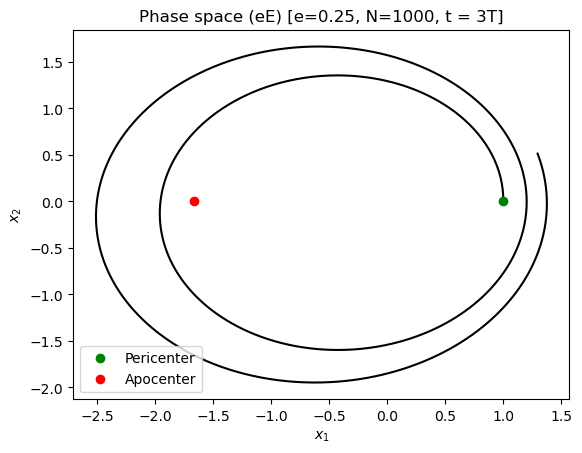

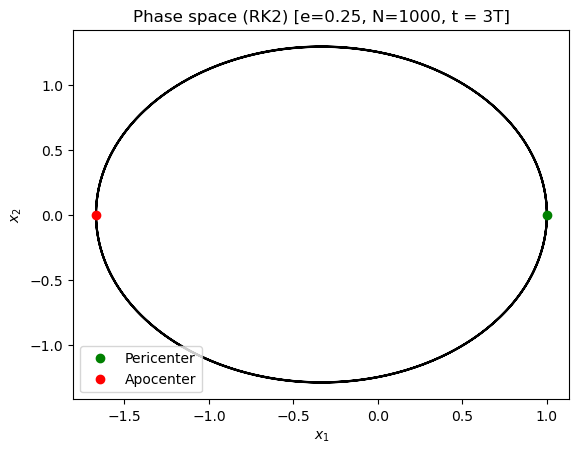

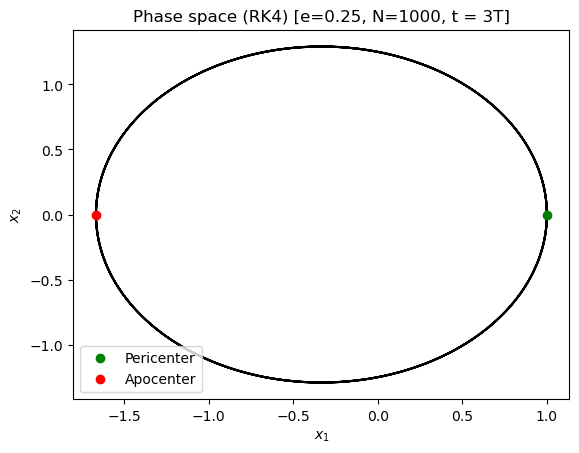

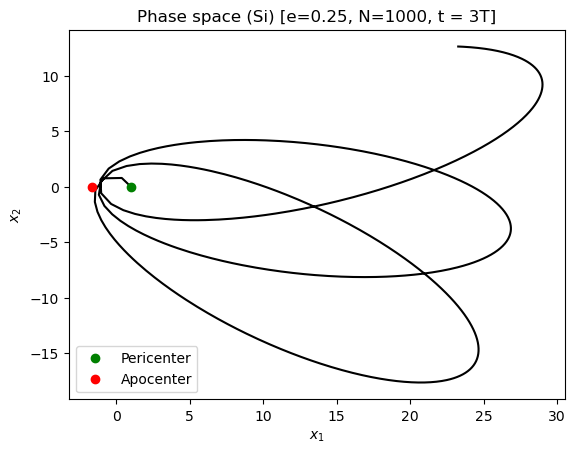

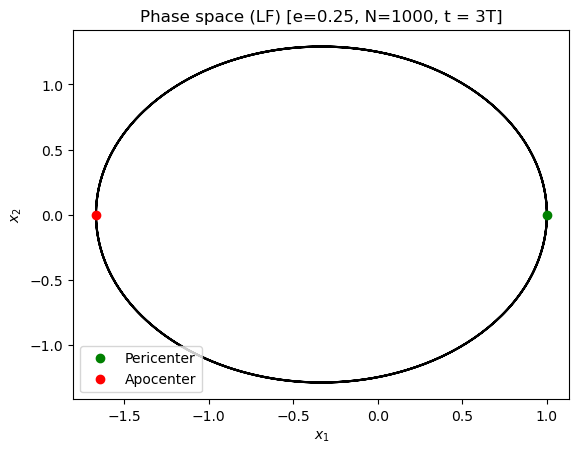

In [38]:
#Pericenter (nearest point to focus)
Px, Py = 1, 0

#Apocenter (further point from focus)
Ax, Ay = -(1+e)/(1-e), 0

for i, key in zip(range(ELz.shape[0]), keys):
    
    y = all_y[i]
    
    #Assigining position and velocity coordinates
    x1 = y[:,0]; x2 = y[:,1]
    
    plt.figure()
    plt.title('Phase space (' + key +') [e=%.2f, N=%.0f, t = %.0fT]' % (e, N, k))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.plot(x1, x2, 'k')
    plt.plot(Px, Py, 'og', label='Pericenter')
    plt.plot(Ax, Ay, 'or', label='Apocenter')
    plt.legend(loc='lower left')

#### Energy

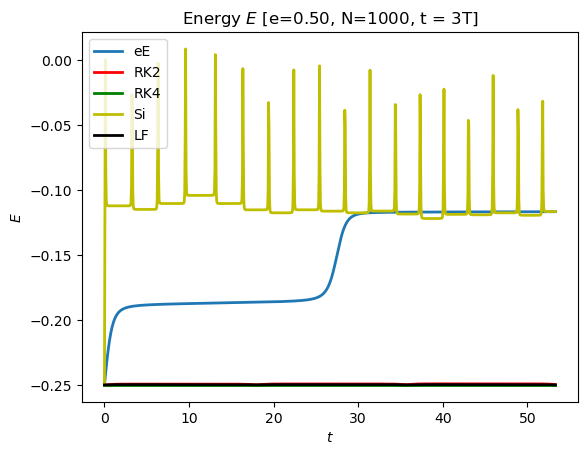

In [26]:
plt.figure()
plt.title('Energy $E$ [e=%.2f, N=%.0f, t = %.0fT]' % (e, N, k))
plt.xlabel('$t$')
plt.ylabel('$E$')

# #Expected energy (defined by eccentricity e)
# plt.plot(t, E*np.ones(N+1), 'dr', markersize=4, label='Energy')

#Calucaled energies (from different numerical methods)
plt.plot(t_eE, E_eE, '-', linewidth=2, label='eE')
plt.plot(t_RK2, E_RK2, 'r-', linewidth=2, label='RK2')
plt.plot(t_RK4, E_RK4, 'g-', linewidth=2, label='RK4')
plt.plot(t_Si, E_Si, 'y-', linewidth=2, label='Si')
plt.plot(t_LF, E_LF, 'k-', linewidth=2, label='LF')

plt.legend(loc='upper left')

#### Angular Momentum

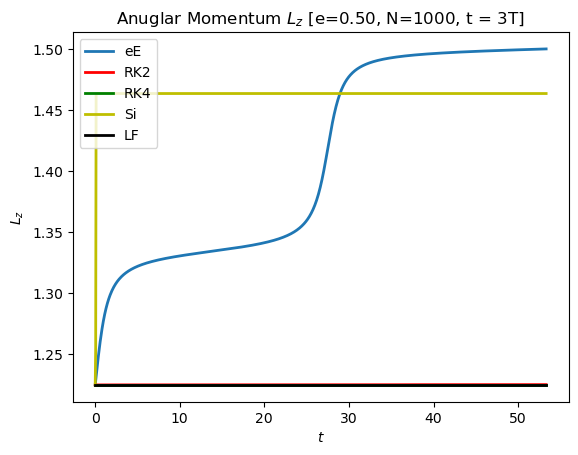

In [27]:
plt.figure()
plt.title('Anuglar Momentum $L_z$ [e=%.2f, N=%.0f, t = %.0fT]' % (e, N, k))
plt.xlabel('$t$')
plt.ylabel('$L_z$')

#Calucaled angular momentum (from different numerical methods)
plt.plot(t_eE, Lz_eE, '-', linewidth=2, label='eE')
plt.plot(t_RK2, Lz_RK2, 'r-', linewidth=2, label='RK2')
plt.plot(t_RK4, Lz_RK4, 'g-', linewidth=2, label='RK4')
plt.plot(t_Si, Lz_Si, 'y-', linewidth=2, label='Si')
plt.plot(t_LF, Lz_LF, 'k-', linewidth=2, label='LF')
plt.legend(loc='upper left')

### Conclusion

The Keplerian orbit of a particle was computed numerically in this  exercise. It's trajectory (phase space), conservation of enegry $E$, conservation of angular momentum $L_z$ were investigated and have been plotted in graphs. The graphs depict these properties of the particle for 10 revolutions, i.e. the timescale $t$ is 10 times larger than the actual period $T$ of the revolution with 1000 iterations $\rightarrow$ $e=0.5$, $N=1000$, $t=10T$. The numerical methods used were the following: explicit Euler (eE), Runge Kutta 2 (RK2), Runge Kutta 4 (RK4), semi implicit Euler (Si) and Leapfrog (LF).

(On a side note, the results weren't as "uniform" as I expected them to be when looking at the phase space for Explicit Euler. For example, these results are for N=1000, t=10T and there are nice complete orbits. For N=500, t=3T the orbit is almost complete. But when I change it to t=5T, it looks very different from what I would have expected. Why is this the case?)

The computational times were also briefly looked at for each method (I did not have to make plots for them however).

#### Phase Space

The most realistic orbits seem to be the ones computed using RK2, RK4 and LF. RK4 either has a closed orbit or it slightly precesses. LF's and RK2's orbits definitely precess. eE's orbit does not seem to follow an ellipse. Lastly, Si does seem to have a closed orbit. But due to its heavy precession, it can not be considered similar to a realistic, expected orbit.

#### Energy Conservation

Energy should be conserved at a value of $E =  -\frac{1-e}{2}$, where $e$ is the eccentricity of the elliptical orbit. This value is not depicted in the energy plot. However, it was checked and the constant value seems to line up pretty well with the values depicted for RK4 and LF, eventhough the latter peaks, plateaus and drops in each cycle of the orbit. eE explodes initially but manages to stay constant. This is only until the 8th orbit, where it explodes again before maintaining a somewhat constant value. RK2 seems to be gaining energy linearly every orbit. And lastly, Si explodes and then seems to hold a constant value apart from some occassional peaks. These seem to occur twice every orbit.

#### Angular Momentum

Angular momentum $L_z = xv_y - yv_x$ should also be conserved. There is no expected value here to compare to, as there was for the energy. However, the time evolution of $L_z$ is similar to that of the energy when looking at the same numerical method. Again, RK4 and LF seem to be the best fits

#### Computational Time

The computational time was very informally checked by looking at how long it takes for a cell to run the numerical methods. In ascending order of time taken, the methods can be sorted as follows: eE (10.5 ms), LF (23 ms), RK2 (69.6 ms), RK4 (88.3 ms) and Si (153 ms). These are just estimated computational times.

#### Best Method?

Judging all aspects, RK4 and LF seem to be the best in all. But since LF is faster, one could consider it more efficient than RK4.